# Análisis datos exámenes dgt Julio 2018 - Junio 2019

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from IPython.display import display, HTML

In [4]:
df = pd.concat([pd.read_csv(f,encoding= 'cp1252',delimiter=';') for f in glob.glob('./data/*.txt')], ignore_index = True)


In [8]:
df.describe()

,CODIGO_SECCION,MES,ANYO,NUM_APTOS,NUM_APTOS_1conv,NUM_APTOS_2conv,NUM_APTOS_3o4conv,NUM_APTOS_5_o_mas_conv,NUM_NO_APTOS
count,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000,390492.000000
mean,2.524879,6.481265,2018.467508,3.113780,1.891486,0.643870,0.437609,0.140815,2.620282
std,3.568686,3.589821,0.498944,4.501126,2.968654,1.206378,1.047882,0.516985,5.141090
min,1.000000,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,7.000000,2018.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,10.000000,2019.000000,4.000000,2.000000,1.000000,1.000000,0.000000,3.000000
max,48.000000,12.000000,2019.000000,375.000000,216.000000,94.000000,85.000000,45.000000,590.000000


In [11]:
df['aptos/total'] = df['NUM_APTOS']/(df['NUM_APTOS'] + df['NUM_NO_APTOS'])

In [16]:
df.columns

Index(['DESC_PROVINCIA', 'CENTRO_EXAMEN', 'CODIGO_AUTOESCUELA',
       'NOMBRE_AUTOESCUELA', 'CODIGO_SECCION', 'MES', 'ANYO', 'TIPO_EXAMEN',
       'NOMBRE_PERMISO', 'NUM_APTOS', 'NUM_APTOS_1conv', 'NUM_APTOS_2conv',
       'NUM_APTOS_3o4conv', 'NUM_APTOS_5_o_mas_conv', 'NUM_NO_APTOS',
       'aptos/total'],
      dtype='object')

In [39]:
#df[df['NOMBRE_PERMISO'] == 'B']
df.drop(df[df.NOMBRE_PERMISO != 'B  '].index, inplace=True)
df.drop(df[df.TIPO_EXAMEN == 'PRUEBA TEÓRICA'].index, inplace=True)

In [ ]:
df.sort_values(by = ['aptos/total','NUM_APTOS'],ascending = False)

### Comparación por meses  autoescuela SAN CRISTOBAL con ABRIL

In [173]:
san_cristobal = df[df['NOMBRE_AUTOESCUELA'] == 'SAN CRISTOBAL']
abril = df[df['NOMBRE_AUTOESCUELA'] == 'ABRIL']
print("\t San Cristobal \t\t Abril")
agg_cristobal = monthly(san_cristobal)
agg_abril = monthly(abril)
pd.merge(agg_cristobal,agg_abril, on = 'MES')

	 San Cristobal 		 Abril


,aptos/total_x,NUM_APTOS_x,aptos/total_y,NUM_APTOS_y
MES,,,,
1,0.497205,141,0.477525,99
2,0.381418,144,0.359807,121
3,0.500091,158,0.402075,136
4,0.511357,167,0.282282,24
5,0.487760,188,0.397066,117
7,0.458973,169,0.402385,92
8,0.541174,129,0.355556,16
9,0.469281,199,0.354241,70
10,0.456593,184,0.393548,83


In [169]:
def monthly(df, imprimir = False):
    monthly_ratio = df[['aptos/total','MES']]
    monthly_aptos = df[['NUM_APTOS','MES']]
    year = pd.merge(monthly_ratio.groupby('MES').mean(),monthly_aptos.groupby('MES').sum(), on = 'MES')
    if (imprimir):
        display(year)
    return year

In [ ]:
df[df['NOMBRE_AUTOESCUELA'] == 'ABRIL'].sum()

In [165]:
provinces = df.iloc[:,[0,9,15]]
res_provinces = pd.merge(
        df[['DESC_PROVINCIA','NUM_APTOS']].groupby('DESC_PROVINCIA').sum(),
        df[['DESC_PROVINCIA','aptos/total']].groupby('DESC_PROVINCIA').mean(),
        on = 'DESC_PROVINCIA')

### Provincias con mayor probabilidad de aprobar el práctico

In [145]:
res_sorted = res_provinces.sort_values(by = ['aptos/total','NUM_APTOS'],ascending = False)
res_sorted.head()

,NUM_APTOS,aptos/total
DESC_PROVINCIA,,
Lugo,2377,0.596643
Cuenca,4783,0.558810
Toledo,10130,0.553633
Lleida,4264,0.545673
Castellón/Castelló,5462,0.534281


## Extraemos coordenadas para cada ciudad 

In [157]:
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = geocoders.Nominatim(user_agent="juanluisrto")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.01)


In [155]:
res_sorted.reset_index(level=0, inplace=True)

#### Filtramos Canarias y melilla

In [246]:
res_sorted = res_sorted[res_sorted['latitude'] > 35]

In [247]:
res_sorted['spain'] = res_sorted['DESC_PROVINCIA'] + ", España"
res_sorted['location'] = res_sorted['spain'].apply(geocode)
res_sorted['latitude'] = res_sorted['location'].apply(lambda x: x.latitude)
res_sorted['longitude'] = res_sorted['location'].apply(lambda x: x.longitude)
res_sorted.drop(columns=['spain','location'])

,DESC_PROVINCIA,NUM_APTOS,aptos/total,latitude,longitude,norm_aptos/total,norm_num_aptos
0,Lugo,2377,0.596643,43.046225,-7.473992,1.000000,0.050008
1,Cuenca,4783,0.558810,40.068116,-2.134824,0.936590,0.100627
2,Toledo,10130,0.553633,39.856068,-4.023957,0.927914,0.213120
3,Lleida,4264,0.545673,41.614761,0.626784,0.914573,0.089708
4,Castellón/Castelló,5462,0.534281,39.986035,-0.037735,0.895479,0.114912
5,Ceuta,714,0.515080,35.888361,-5.304138,0.863298,0.015021
6,Pontevedra,7552,0.511188,42.607517,-8.471494,0.856774,0.158882
7,Ciudad Real,4691,0.504801,38.959751,-3.882828,0.846070,0.098691
8,Araba/Álava,2618,0.504257,42.844317,-2.682203,0.845157,0.055079
9,Gipuzkoa,5317,0.503531,43.144528,-2.203796,0.843941,0.111861


In [276]:
dims = res_sorted[['NUM_APTOS','aptos/total']]
ratio = (dims - dims.min())/(dims.max() - dims.min())
res_sorted ['norm_aptos/total'] = ratio['aptos/total']
res_sorted ['norm_num_aptos'] = ratio['NUM_APTOS']

## Montamos el mapa

In [241]:
import numpy as np
import shapefile as shp
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.cm as cm

In [277]:
geometry = [Point(xy) for xy in zip(res_sorted.longitude, res_sorted.latitude)]
df = res_sorted.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
Z = [[0,0],[0,0]]
levels = range(0,110,10)
CS3 = plt.contourf(Z, levels, cmap = 'RdYlGn')
CS3.ax.set_ylabel('% alumnos aprobados', rotation=270)
plt.clf()

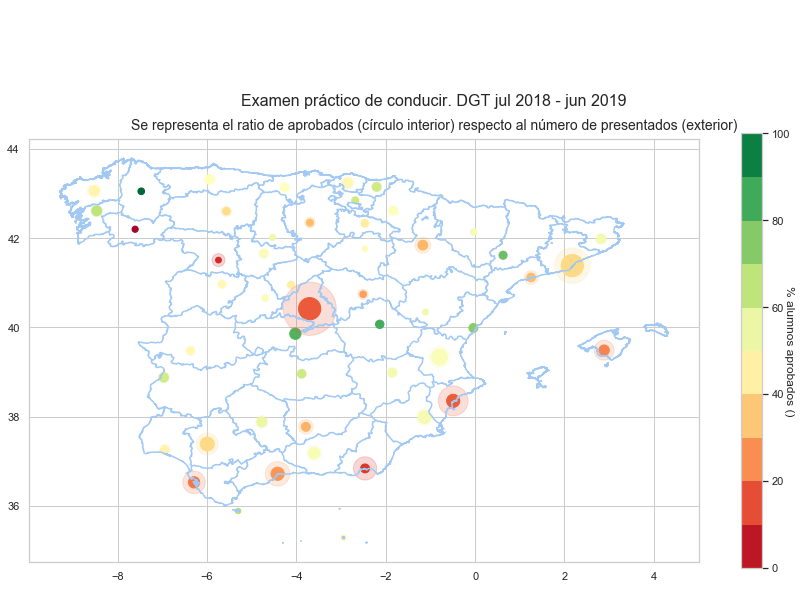

In [364]:
m = 0.01
n = 20
spain_map = gpd.read_file('./peninsula/ll_provinciales_inspire_peninbal_etrs89.shp')
fig,ax = plt.subplots(figsize = (15,10))
fig.suptitle("\n\n\n\n\nExamen práctico de conducir. DGT jul 2018 - jun 2019", fontsize=16)
plt.figtext(.5,.81,'Se representa el ratio de aprobados (círculo interior) respecto al número de presentados (exterior)',fontsize=14,ha='center')

spain_map.plot(ax = ax)
colors = cm.RdYlGn(gdf['norm_aptos/total'])
gdf.plot(ax = ax, markersize = (m*(gdf['NUM_APTOS']) + n), color = colors , marker = 'o')
gdf.plot(ax = ax, markersize = (m*(gdf['NUM_APTOS']/gdf['norm_aptos/total']) + n), color = colors , marker = 'o', alpha = 0.2)
plt.colorbar(CS3,shrink = 0.8).ax.set_ylabel('% alumnos aprobados ()', rotation=270)
plt.savefig("./awesome_graph_dgt.png")
plt.show()